# Simple Credit Model Exploration - Nikul Patel

In [7]:
!pip install openpyxl > /dev/null # to read excel file

In [2]:
import pandas as pd
import numpy as np

def read_standard_trades(trade_file):
    """Load data and filter to standard trades."""
    data = pd.read_excel(trade_file)
    epd = pd.to_datetime(data["Expected Payment Date"]).dt.date # 
    data.loc[:, "Expected Payment Date"] = pd.to_datetime(epd)
    return data.loc[data["Trade Type"]=="Standard"].sort_values(by="Advance Date").reset_index(drop=True)

In [10]:
data = read_standard_trades("./Public_Loan_Book.xlsx")
data.head()

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Advance,Advance %,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss
0,67,11,Standard,2011-03-09,2011-03-18,2011-03-25,No,NaT,NaT,Paid,...,16466.7600,90.0,1.00,Facevalue,0.0,18296.40,16466.7600,0.0,14.164039,NaN
1,68,6,Standard,2011-03-22,2011-04-22,2011-05-16,No,NaT,NaT,Paid,...,16486.2000,90.0,1.00,Facevalue,0.0,18318.00,16486.2000,0.0,14.164039,NaN
2,69,9,Standard,2011-03-31,2011-04-28,2011-05-13,No,NaT,NaT,Paid,...,3209.8295,85.0,1.85,Facevalue,0.0,3776.27,3209.8295,0.0,29.384044,NaN
3,70,11,Standard,2011-04-05,2011-05-01,2011-05-05,No,NaT,NaT,Paid,...,12150.0000,90.0,1.00,Facevalue,0.0,13500.00,12150.0000,0.0,14.164039,NaN
4,71,12,Standard,2011-04-06,2011-04-30,2011-04-08,No,NaT,NaT,Paid,...,14688.0000,85.0,2.00,Facevalue,0.0,17280.00,14688.0000,0.0,32.146043,NaN


### Data Quality
Let's check the data quality first. There are missing values for four fields: Settlement Date, In Arrears ...

... Since no Advance Dates are missing, the missing settlement dates are probably from trades that haven't been paid. We'll check this explicitly.

The other three fields are read as roughly 98% missing, but these seem to be only relevant for delinquent/in arrears loans.

In [19]:
missing_fields = 100 * data.isna().sum(axis=0).sort_values() / len(data)
missing_fields[missing_fields!=0]
# np.isnat(data.loc[:, data.dtypes==np.dtype('<M8[ns]')]).sum(axis=0)

Settlement Date            3.511489
In Arrears on Date        98.109198
Crystallised Loss         98.109198
Crystallised Loss Date    98.354102
dtype: float64

We see roughly 2.8% of data are non settled loans that aren't in arrears. Looking at the advance dates it seems these are the latest loans for which we don't know the outcome. I'm not sure if these can be used for inference since they could close in arrears.

I will ignore this however since they have been labelled as not in arrears.

In [62]:
df = data.loc[(data["In Arrears"]=="No") & data["Settlement Date"].isna()]
print("Perc not in arrears missing settlement dates: ", len(df) / len(data))
print("Settlement dates start: ", data["Advance Date"].min())
print("Settlement dates end: ", data["Advance Date"].max())
df.sort_values(by="Advance Date")

Perc not in arrears missing settlement dates:  0.028019880429302025
Settlement dates start:  2011-03-09 00:00:00
Settlement dates end:  2018-10-11 00:00:00


,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Advance,Advance %,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss
25041,55415,47187,Standard,2018-05-30,2018-09-03,NaT,No,NaT,NaT,Overdue,...,22092.09,75.0,0.9,Advance,22092.09,29456.1200,22092.0900,22092.0900,11.350967,NaN
25158,55584,46779,Standard,2018-06-04,2018-08-17,NaT,No,NaT,NaT,Repurchase Demanded,...,31875.00,85.0,0.9,Advance,4475.00,37500.0000,31875.0000,4475.0000,11.350967,NaN
25219,55801,10764,Standard,2018-06-07,2018-09-05,NaT,No,NaT,NaT,Repurchase Demanded,...,32300.00,85.0,0.9,Advance,26268.82,38000.0000,32300.0000,26268.8200,11.350967,NaN
25254,55839,2353,Standard,2018-06-08,2018-09-14,NaT,No,NaT,NaT,Repurchase Demanded,...,24605.10,85.0,0.9,Advance,24605.10,28947.1800,24605.1000,24605.1000,11.350967,NaN
25270,55534,790,Standard,2018-06-08,2018-10-12,NaT,No,NaT,NaT,Partially Paid,...,199775.46,55.0,0.9,Advance,199775.46,271107.7183,149109.2488,149109.2488,11.350967,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27735,61341,47365,Standard,2018-10-11,2018-12-11,NaT,No,NaT,NaT,Awaiting Repayment,...,8388.10,80.0,0.7,Advance,8388.10,10485.1200,8388.1000,8388.1000,8.731066,NaN
27734,61323,27854,Standard,2018-10-11,2018-11-16,NaT,No,NaT,NaT,Awaiting Repayment,...,5853.27,55.0,0.9,Advance,5853.27,10642.3100,5853.2700,5853.2700,11.350967,NaN
27764,61250,18507,Standard,2018-10-11,2018-12-14,NaT,No,NaT,NaT,Awaiting Repayment,...,5118.92,60.0,0.7,Advance,5118.92,8531.5400,5118.9200,5118.9200,8.731066,NaN
27749,61311,11655,Standard,2018-10-11,2018-12-08,NaT,No,NaT,NaT,Awaiting Repayment,...,15300.00,85.0,0.9,Advance,15300.00,18000.0000,15300.0000,15300.0000,11.350967,NaN


In [52]:
data.groupby("In Arrears")["Crystallised Loss"].value_counts(dropna=False) # it seems Crystallised loss is only relevant for loans in arrears

In Arrears  Crystallised Loss
No          NaN                  27241
Yes         Yes                    456
            No                      69
Name: Crystallised Loss, dtype: int64

### Initial Features
Let's add the requested features: expected duration and number of previously settled trades. Use the functions `calc_num_settled` and `calc_exp_duration` below to calculate these.

Note: `calc_num_settled` can be optimised. I don't do this here for simplicity.

In [66]:
def _calc_num_settled_group(df):
    curr_adv_date = df["Advance Date"].iloc[-1]
    return (df["Settlement Date"] < curr_adv_date).sum()
    

def calc_num_settled_group(df):
    """Calculate the number of settled trades for a single seller id before a
    given trade is opened.
    
    #FIXME: This runs in O(N^2), could do in O(N) by traversing once
    """
    num_settled = {ind: _calc_num_settled_group(df.loc[:ind]) for ind in df.index}
    return pd.Series(num_settled, name="Num Settled")


def calc_num_settled(df) -> pd.Series:
    """Calculate the number of settled trades before trades are opened.
    """
    num_settled = df.groupby("Seller ID").apply(calc_num_settled_group)
    return num_settled.droplevel(0).sort_index()


def calc_exp_duration(df) -> pd.Series:
    exp_duration = (data['Expected Payment Date'] - data['Advance Date']).dt.days
    return exp_duration.rename("Expected Duration")

In [116]:
data.loc[:, "num_settled"] = calc_num_settled(data)
data.loc[:, "exp_duration"] = calc_exp_duration(data)

#### Feature Checks
Let's check these are implemented correctly for some examples

In [122]:
data[data["Seller ID"]==2399][["Advance Date", "Settlement Date", "num_settled"]].head(10) # correct for this seller id

,Advance Date,Settlement Date,num_settled
1867,2014-01-17,2014-02-14,0
1927,2014-01-28,2014-02-28,0
1997,2014-02-05,2014-03-07,0
2040,2014-02-12,2014-03-14,0
2087,2014-02-18,2014-03-21,1
2088,2014-02-18,2014-03-21,1
2138,2014-02-26,2014-03-28,1
2200,2014-03-04,2014-03-31,2
2230,2014-03-10,2014-04-11,3
2250,2014-03-12,2014-04-22,3


In [133]:
data.groupby("Seller ID")["num_settled"].diff().value_counts() # also always >=0. Note: possible bug - many large (>10) increases in num_settled?

0.0     13778
1.0      6657
2.0      3113
3.0      1326
4.0       639
5.0       311
6.0       151
7.0        85
8.0        60
9.0        39
10.0       20
12.0        8
11.0        6
13.0        4
15.0        3
16.0        2
14.0        1
17.0        1
18.0        1
19.0        1
24.0        1
Name: num_settled, dtype: int64

Note: there are 13 rows with expected duration < 0. This could be from data entry errors or from carried forward loans.

It would be sensible to drop these, but for simplicity let's keep these (it affects 0.05% of rows so shouldn't significantly affect results).

In [127]:
neg_exp_dur = data[data["exp_duration"] < 0]
print(100 * len(neg_exp_dur) / len(data))
neg_exp_dur

0.04681985161708564


,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss,num_settled,exp_duration
11,83,11,Standard,2011-05-10,2011-04-22,2011-06-02,No,NaT,NaT,Paid,...,1.0,Facevalue,0.0,8640.0000,7776.0000,0.0,14.164039,NaN,2,-18
21,80,11,Standard,2011-06-23,2011-04-22,2011-08-26,No,NaT,NaT,Paid,...,1.0,Facevalue,0.0,5760.0000,5184.0000,0.0,14.164039,NaN,5,-62
2542,8497,8131,Standard,2014-05-01,2014-04-29,2014-06-05,No,NaT,NaT,Paid,...,0.8,Facevalue,0.0,12480.0000,10608.0000,0.0,11.881841,NaN,0,-2
4938,13147,1018,Standard,2015-03-04,2015-03-01,2015-03-06,No,NaT,NaT,Paid,...,0.8,Facevalue,0.0,3664.7378,3115.0337,0.0,11.881841,NaN,31,-3
7400,16546,16005,Standard,2015-08-26,2015-08-16,2015-09-04,No,NaT,NaT,Paid,...,0.9,Advance,0.0,1022.6500,869.2800,0.0,11.350967,NaN,0,-10
8684,19566,11508,Standard,2015-11-06,2015-11-04,2015-12-07,No,NaT,NaT,Paid,...,1.2,Advance,0.0,12000.0000,9600.0000,0.0,15.389462,NaN,33,-2
12656,26870,20043,Standard,2016-06-22,2016-06-05,2016-06-27,No,NaT,NaT,Paid,...,0.9,Advance,0.0,43752.3000,37189.5000,0.0,11.350967,NaN,4,-17
13171,29154,19810,Standard,2016-07-21,2016-07-15,2016-08-22,No,NaT,NaT,Paid,...,1.4,Advance,0.0,2722.6500,2314.2700,0.0,18.155913,NaN,5,-6
14756,32603,4743,Standard,2016-10-19,2016-01-15,2016-11-01,No,NaT,NaT,Repurchased,...,0.7,Advance,0.0,5279.0000,4751.1000,0.0,8.731066,NaN,90,-278
14839,32648,24633,Standard,2016-10-24,2016-10-19,2016-10-24,No,NaT,NaT,Repurchased,...,0.9,Advance,0.0,10997.5700,9347.9000,0.0,11.350967,NaN,9,-5


### Target inspection
Let's look at the target distribution: roughly 1.9% of all loans are in arrears.

This is heavily skewed as expected since most loans should not be in arrears.

In [147]:
data["In Arrears"].value_counts(normalize=True)

No     0.981092
Yes    0.018908
Name: In Arrears, dtype: float64

## Model Fitting (step 2)
Let's now fit a logistic regression model. Since the target classes are imbalanced we make two adjustments:

1) Adjust weights to account for this (increase weights for samples that are in arrears)
2) Evaluate performance using AUC.
    - This is scale invariant and measures how well the model separates classes - this is of interest.
   Other metrics have issues:
    - Accuracy: We can get a good accuracy by approving all loans since there is a large class imbalance.
    - Precision: False positives (in arrears loans) should be minimised so improving precision is of interest, but this can be maximised by approving no loans.

Note: Maximising the expected value from trades should be the objective. This can be proxied by a combination of precision and recall (eg Fbeta), but requires calibration for the threshold (could get this from exposure constraints) and for beta.


#### Train/Test sets
To evaluate performance we train and test on two separate sets. This data is a time series, so I see two ways to do this:
1) Use stratified sampling to split into two sets, each with the same target class ratios
  - This will leak forward information
2) Do a time series split: eg train on all samples from before 2017-01-01 and test on samples after 2017-01-01
  - This generally will not preserve target class ratios (the test set could have a different class ratio)


For scoring simplicity I will use 1) (AUC is scale invariant, but it could still be sensitive to changes in class distribution).

In [504]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(data["In Arrears"])
data.loc[:, "target"] = label_encoder.transform(data["In Arrears"]) # change "No", "Yes" to [0, 1]

In [377]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5).split(data[features], data[target])
train_ind, test_ind = list(skf)[-1] # test is mostly after train
print(len(test_ind)/len(data)) # 20% is test data
train_ind, test_ind

0.19999279694590508


(array([    0,     1,     2, ..., 22264, 22265, 22266]),
 array([20934, 20941, 20948, ..., 27763, 27764, 27765]))

In [378]:
print("Train class ratio:") # check class ratios are the same in train and test
print(data['target'].iloc[train_ind].value_counts(normalize=True))

print("\nTest class ratio:")
print(data['target'].iloc[test_ind].value_counts(normalize=True))

Train class ratio:
0    0.981092
1    0.018908
Name: target, dtype: float64

Test class ratio:
0    0.981091
1    0.018909
Name: target, dtype: float64


### Initial Model Fitting
Let's fit the model on the train data and evaluate on the test data using the two previously calculated features: num_settled and exp_duration.

Define a `train_evaluate` function for convenience to train and evaluate models.

In [379]:
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

def score_model(model, features_df, target_df):
    """Calculate predictions and AUC score using the given fitted model.
    """
    preds = model.predict_proba(features_df)[:, 1]
    return roc_auc_score(target_df, preds)


def train_evaluate(model, train_data, test_data, features):
    """Convenience function to train and evaluate a model to predict the "target" column
    in the given data using the given list of features and returns the model and AUC evaluations
    on train and test.
    """
    trained_model = clone(model).fit(train_data[features], train_data["target"])
    
    score_in_sample = score_model(trained_model, train_data[features], train_data["target"])
    score_oo_sample = score_model(trained_model, test_data[features], test_data["target"])
    
    return {"model": trained_model, "auc_is": score_in_sample, "auc_oos": score_oo_sample}

In [380]:
from sklearn.linear_model import LogisticRegression

features = ["num_settled", "exp_duration"]
model = LogisticRegression(penalty="none", class_weight="balanced")
init_model_eval = train_evaluate(model, data.iloc[train_ind], data.iloc[test_ind], features)
print("In sample AUC: ", init_model_eval["auc_is"])
print("Out of sample AUC: ", init_model_eval["auc_oos"])

print("Model coefficients: ", dict(zip(features, init_model_eval["model"].coef_[0])))

In sample AUC:  0.5922832364258511
Out of sample AUC:  0.6708228445563247
Model coefficients:  {'num_settled': -0.00044515920284191274, 'exp_duration': 0.015378777152301548}


We make a few observations:
- The OOS AUC score is > 0.5: the model is better than a dummy classifier, so we have learned something from the data
  - (can be more confident about this via bootstrapping or CV)
- The OOS score is better than the in sample score
  - This could be due to underfitting the test set
  - ... or because the test set is smaller, this could be expected (eg the p-values could still be ordered as expected due to the different sample sizes)
- The model coefficients are sensible:
  - eg num_settled has a negative coefficient: the more previously settled loans a seller has the lower the probability of being in arrears.
  - similarly for expected duration.

### Step 3
Let's plot the relationship between num_settled and in arrears and calculate some statistics.

We see two clear patterns:
- The more num settled is, the less likely a trade is in arrears
- There are very few trades in arrears having num_settled > 200

The first of these is already captured in our model. We can also add an indicator for the second condition

In Arrears            No         Yes
count       21793.000000  420.000000
mean           35.295141   35.026190
std            50.958242   59.922757
min             0.000000    0.000000
25%             3.000000    1.000000
50%            15.000000    7.500000
75%            46.000000   34.000000
max           381.000000  223.000000


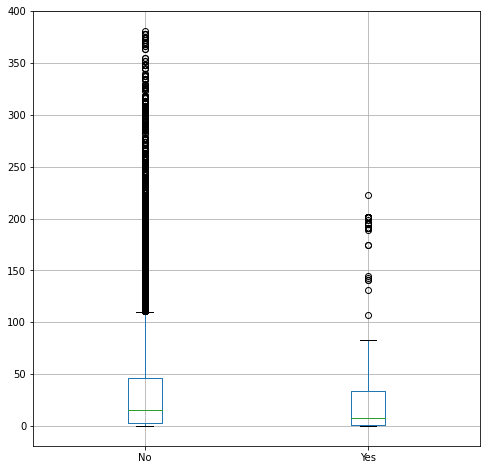

In [389]:
num_sett_tgt = data.iloc[train_ind].pivot(columns="In Arrears", values="num_settled") # subset on train data to avoid snooping on test set
num_sett_tgt.boxplot(figsize=(8,8))
print(num_sett_tgt.describe())

Let's add this feature and re-evaluste on the test set.

We do slightly worse than before on the test set (but achieve a better in sample score): surprising since we are still underfitting (we do better on test than train) and we have added another feature, but the difference could be statistically insignificant (we're also not really adding more information since it is derived from an existing field).

In [375]:
data.loc[:, "num_settled_200"] = data["num_settled"] > 200

features = ["num_settled", "exp_duration", "num_settled_200"]
model = LogisticRegression(penalty="none", class_weight="balanced")
upd_model_eval = train_evaluate(model, data.iloc[train_ind], data.iloc[test_ind], features)
print("In sample AUC: ", upd_model_eval["auc_is"])
print("Out of sample AUC: ", upd_model_eval["auc_oos"])

print("Model coefficients: ", dict(zip(features, upd_model_eval["model"].coef_[0])))

In sample AUC:  0.6287646972706395
Out of sample AUC:  0.6601540102090763
Model coefficients:  {'num_settled': -0.005312398284652415, 'exp_duration': 0.017619755722713442, 'num_settled_200': 2.2250423192432085}


### Step 4 - Further Modelling
Since we see underfitting on the train set, it makes sense to use a more complex model. This means either:
- More features
- A more complex underlying model

To create more features I will construct some unitless quantities that are intuitively sensible and include some existing categorical features.

I will also use a more complex model (LGBM):
- Introduces more model complexity (it has more degrees of freedom per input feature than the logistic regression model we used earlier)
- Introduces non-linearities and so can capture more complex patterns in the data
- Invariant under (monotonic) feature transformations and robust to outliers, so don't have to worry about feature normalisation


#### Features
I note the features I'm adding with brief reasons why I'm including them:
- "Price Grade" (existing): This seems to be related to the quality of a seller
- "Payment State" (existing): non-paid loans could indicate issues with sellers' ability to repay
- 'Annualised Gross Yield %' (existing): riskier trades demand higher yields to compensate for this risk
- "perc_paid" = Outstanding Principal (GBP) / Face Value (GBP): the less left to pay the less likely a trade will be in arrears
- "num_in_arrears" = # of loans that were previously in arrears for a seller: 

... there are other possibly useful features to do with seller's track records (eg more statistics from previous trades/about current open trades) and macroeconomic variables (eg can be proxied by GBP borrowed in past week/month etc). For simplicity let's stick with these.

Let's check first how well an LGBM model does with the same features as before. Here I change some parameters to restrict model complexity since there are only two features.

We get a similar out of sample score, so I suspect we're not limited by the model itself but rather by the input features (the in sample score increases as expected since the number of parameters is greater).

In [503]:
import lightgbm

features = ["num_settled", "exp_duration"]
model = lightgbm.LGBMClassifier(is_unbalance=True, num_leaves=3, n_estimators=10)
init_lgbm_model_eval = train_evaluate(model, data.iloc[train_ind], data.iloc[test_ind], features)
print("In sample AUC: ", init_lgbm_model_eval["auc_is"])
print("Out of sample AUC: ", init_lgbm_model_eval["auc_oos"])

importances = pd.Series(init_lgbm_model_eval["model"].feature_importances_, index=features).sort_values()
print("Feature importances:")
print(importances / importances.sum())

In sample AUC:  0.7105374049771334
Out of sample AUC:  0.6417531990769877
Feature importances:
exp_duration    0.35
num_settled     0.65
dtype: float64


In [424]:
from sklearn.preprocessing import LabelEncoder

def _calc_num_in_arrears_group(df):
    curr_adv_date = df["Advance Date"].iloc[-1]
    # FIXME: using target column here for convenience, could easily leak forward information if not careful.
    return df.loc[df["Advance Date"] < curr_adv_date, "target"].sum()
    

def calc_num_in_arrears_group(df):
    """#FIXME: This runs in O(N^2), could do in O(N) by traversing once
    """
    num_in_arrears = {ind: _calc_num_in_arrears_group(df.loc[:ind]) for ind in df.index}
    return pd.Series(num_in_arrears, name="num_in_arrears")


def calc_num_in_arrears(df):
    """TODO: check whether this is bug-free. 
    """
    num_in_arrears = df.groupby("Seller ID").apply(calc_num_in_arrears_group)
    return num_in_arrears.droplevel(0).sort_index()


data.loc[:, "perc_paid"] = data['Outstanding Principal (GBP)'] / data['Face Value (GBP)'].fillna(0)
data.loc[:, "price_grade_label"] = LabelEncoder().fit_transform(data["Price Grade"].apply(str))
data.loc[:, "payment_state_label"] = LabelEncoder().fit_transform(data["Payment State"].apply(str))
data.loc[:, "num_in_arrears"] = calc_num_in_arrears(data)

In [488]:
import lightgbm

features = ["price_grade_label", "payment_state_label", 'num_settled', 'exp_duration', 'Annualised Gross Yield %', "perc_paid", "num_in_arrears"]
categorical_feats = [0, 1] # need to tell LGBM model which are categorical features
model = lightgbm.LGBMClassifier(categorical_features=categorical_feats, is_unbalance=True) # keep default parameters for simplicity

lgbm_model_eval = train_evaluate(model, data.iloc[train_ind], data.iloc[test_ind], features)
print("In sample AUC: ", lgbm_model_eval["auc_is"])
print("Out of sample AUC: ", lgbm_model_eval["auc_oos"])

importances = pd.Series(lgbm_model_eval["model"].feature_importances_, index=features).sort_values()
print("Feature importances:")
print(importances / importances.sum())

In sample AUC:  0.9973703329815384
Out of sample AUC:  0.9313570729319628
Feature importances:
perc_paid                   0.016333
payment_state_label         0.031000
price_grade_label           0.034000
num_in_arrears              0.073667
Annualised Gross Yield %    0.158000
num_settled                 0.325000
exp_duration                0.362000
dtype: float64


### Final Comments
This is a significant improvement over the previous AUC scores. Looking at the feature importances this doesn't seem to be a bug (specifically from the num_in_arrears feature - if this leaked information the importance would've been much higher. The other features most likely don't leak information since their construction is simple).

I suspect this can further be improved by hyperparameter tuning (possibly overfit since the in sample AUC is close to 1 and much higher than the out of sample score).

